In [10]:
import os
import sys
import librosa
import numpy as np
import pandas as pd
from scipy.stats import norm
from tqdm import tqdm_notebook as tqdm
from multiprocessing import Pool
from matplotlib import pylab as plt
from collections import Counter
from TTS.config.shared_configs import BaseDatasetConfig
from TTS.tts.datasets import load_tts_samples
from TTS.tts.datasets.formatters import *
%matplotlib inline

In [11]:
NUM_PROC = 1
DATASET_CONFIG = BaseDatasetConfig(
     meta_file_train="metadata.csv", path="D:/THESIS/TTS_40HRS/Telugu_M/Telugu_M",language="te" 
)

In [12]:
def formatter(root_path, meta_file, **kwargs):  # pylint: disable=unused-argument
    txt_file = os.path.join(root_path, meta_file)
    items = []
    with open(txt_file, "r", encoding="utf-8") as ttf:
        for line in ttf:
            cols = line.split("|")
            wav_file = os.path.join(root_path, "wavs", cols[0] + ".wav")            
            text = cols[1].strip()
            speaker_name = cols[2].strip()
            root_path="D:/THESIS/TTS_40HRS/Telugu_M/Telugu_M/"
            items.append({"text": text, "audio_file": wav_file, "speaker_name": speaker_name,"root_path":root_path})
    return items

# output_path = "tts_train_dir"
# if not os.path.exists(output_path):
#     os.makedirs(output_path)

male = True



In [13]:
train_samples, eval_samples = load_tts_samples(DATASET_CONFIG, eval_split=True, formatter=formatter)
if eval_samples is not None:
    items = train_samples + eval_samples
else:
    items = train_samples
print(" > Number of audio files: {}".format(len(items)))
for i in range(6435):
    items[i]['text']=items[i]['text'].replace('\u200c', ' ')
for i in range(6435):
    texts = "".join(items[i]["text"])
    lang_chars = sorted(list(set(texts)))
print(lang_chars, len(lang_chars))    

 | > Found 16835 files in D:\THESIS\TTS_40HRS\Telugu_M\Telugu_M
 > Number of audio files: 16835
[' ', '.', ':', 'ం', 'క', 'చ', 'ఛ', 'జ', 'ట', 'డ', 'ఢ', 'త', 'న', 'ప', 'బ', 'భ', 'మ', 'య', 'ర', 'ల', 'ళ', 'ష', 'స', 'ా', 'ి', 'ీ', 'ు', 'ూ', 'ె', 'ో', '్'] 31


In [14]:
# check wavs if exist
wav_files = []
for item in items:
    wav_file = item["audio_file"].strip()
    wav_files.append(wav_file)
    if not os.path.exists(wav_file):
        print(wav_file)

In [15]:
# show duplicate items
c = Counter(wav_files)
print([item for item, count in c.items() if count > 1])

[]


In [16]:
item

{'text': 'శస్త్ర చికిత్స ద్వారా దంత సంబంధిత ఇంప్లాంట్స్ ను కింది దవడ ఎముకకు చేర్చుతారు.',
 'audio_file': 'D:/THESIS/TTS_40HRS/Telugu_M/Telugu_M/wavs\\te_m_health_02579.wav',
 'speaker_name': 'male',
 'root_path': 'D:/THESIS/TTS_40HRS/Telugu_M/Telugu_M/',
 'language': 'te',
 'audio_unique_name': '#wavs\\te_m_health_02579'}

In [9]:
def load_item(item):
    text = item["text"].strip()
    #print(text)
    file_name = item["audio_file"].strip()
    audio, sr = librosa.load(file_name, sr=None)
    audio_len = len(audio) / sr
    text_len = len(text)
    return file_name, text, text_len, audio, audio_len

# This will take a while depending on size of dataset
if NUM_PROC == 1:
    data = []
    for m in tqdm(items):
        data += [load_item(m)]
else:
    with Pool(8) as p:
        data = list(tqdm(p.imap(load_item, items), total=len(items)))

100%|██████████| 16835/16835 [09:02<00:00, 31.04it/s] 


In [18]:
data[0]

('D:/THESIS/TTS_40HRS/Telugu_M/Telugu_M/wavs\\te_m_health_02633.wav',
 'అంతేకాకుండా, మీ డాక్టర్ మీకు చెప్పినట్లుగా, రక్తపోటుకు చికిత్స చేయడం వలన గుండెపోటు వచ్చే ప్రమాదాన్ని తగ్గిస్తుంది.',
 114,
 array([-6.1035156e-05,  1.5258789e-04,  9.1552734e-05, ...,
         9.1552734e-05,  9.1552734e-05,  1.2207031e-04], dtype=float32),
 7.1)

In [39]:
durs = [item[-1] for item in data]
total_seconds = sum(durs)
total_hours = total_seconds // 3600  # Integer division to get total hours
remaining_seconds = total_seconds % 3600  # Remaining seconds after converting to hours
minutes, seconds = divmod(remaining_seconds, 60)  # Calculate minutes and seconds using divmod

print(f"Duration: {total_hours} hours, {minutes} minutes, {seconds} seconds")

Duration: 41.0 hours, 46.0 minutes, 43.52934240401373 seconds


In [20]:
# count words in the dataset
w_count = Counter()
for item in tqdm(data):
    text = item[1].lower().strip()
    for word in text.split():
        w_count[word] += 1
print(" > Number of words: {}".format(len(w_count)))

100%|██████████| 16835/16835 [00:00<00:00, 94553.97it/s]

 > Number of words: 83306


In [21]:
text_vs_durs = {}  # text length vs audio duration
text_len_counter = Counter()  # number of sentences with the keyed length
for item in tqdm(data):
    text = item[1].lower().strip()
    text_len = len(text)
    text_len_counter[text_len] += 1
    audio_len = item[-1]
    try:
        text_vs_durs[text_len] += [audio_len]
    except:
        text_vs_durs[text_len] = [audio_len]

100%|██████████| 16835/16835 [00:00<00:00, 107434.99it/s]


In [22]:
# text_len vs avg_audio_len, median_audio_len, std_audio_len
text_vs_avg = {}
text_vs_median = {}
text_vs_std = {}
for key, durs in text_vs_durs.items():
    text_vs_avg[key] = np.mean(durs)
    text_vs_median[key] = np.median(durs)
    text_vs_std[key] = np.std(durs)

In [23]:
for item in data:
    if item[-1] <= 1:
        print(item)

In [24]:
sec_per_chars = []
for item in data:
    text = item[1]
    dur = item[-1]
    sec_per_char = dur / len(text)
    sec_per_chars.append(sec_per_char)
# sec_per_char /= len(data)
# print(sec_per_char)

In [25]:
mean = np.mean(sec_per_chars)
std = np.std(sec_per_chars)
print(mean)
print(std)

0.07304047540463973
0.006848798086128158


In [26]:
dist = norm(mean, std)

# find irregular instances long or short voice durations
for item in data:
    text = item[1]
    dur = item[-1]
    sec_per_char = dur / len(text)
    pdf =norm.pdf(sec_per_char)
    if pdf < 0.39:
        print(item)
        pass

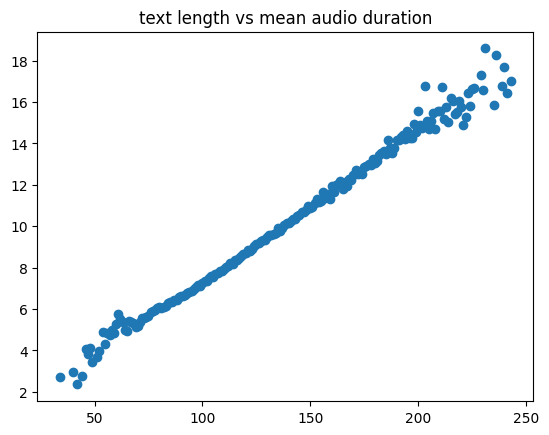

In [27]:
plt.title("text length vs mean audio duration")
plt.scatter(list(text_vs_avg.keys()), list(text_vs_avg.values()))

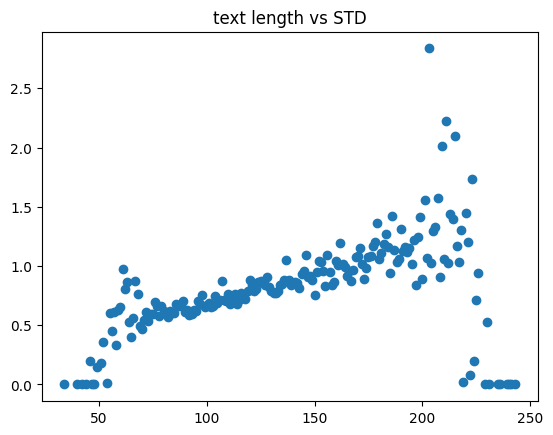

In [29]:
plt.title("text length vs STD")
plt.scatter(list(text_vs_std.keys()), list(text_vs_std.values()))

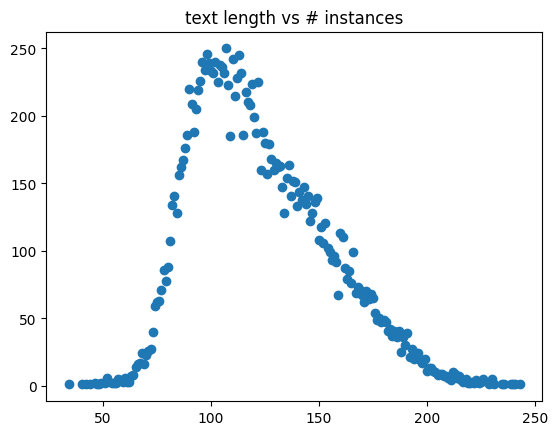

In [30]:
plt.title("text length vs # instances")
plt.scatter(list(text_len_counter.keys()), list(text_len_counter.values()))

100%|██████████| 16835/16835 [00:00<00:00, 401185.80it/s]


Text(0.5, 1.0, 'audio length distribution')

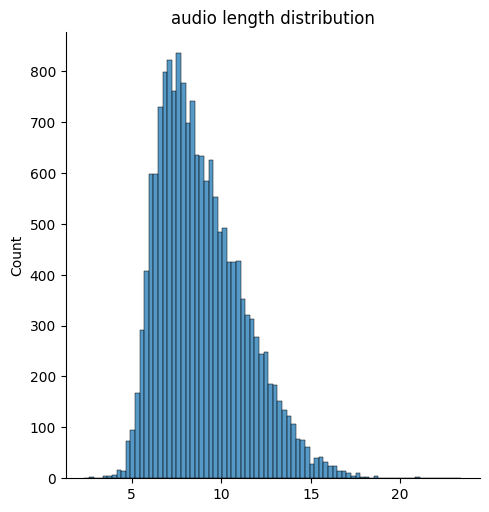

In [31]:
import seaborn as sns
audio_lens = []
for item in tqdm(data):
    audio_len = item[-1]
    audio_lens.append(audio_len)

sns.displot(audio_lens)
plt.title("audio length distribution")

In [32]:
w_count_df = pd.DataFrame.from_dict(w_count, orient='index')
w_count_df.sort_values(0, ascending=False, inplace=True)

In [33]:
w_count_df

,0
మరియు,2556
ఈ,2204
ఒక,1464
యొక్క,1220
కూడా,1028
...,...
గాంధీచౌక్లో,1
మహాత్మునితో,1
జాతినేతల,1
పూలమాలలు,1


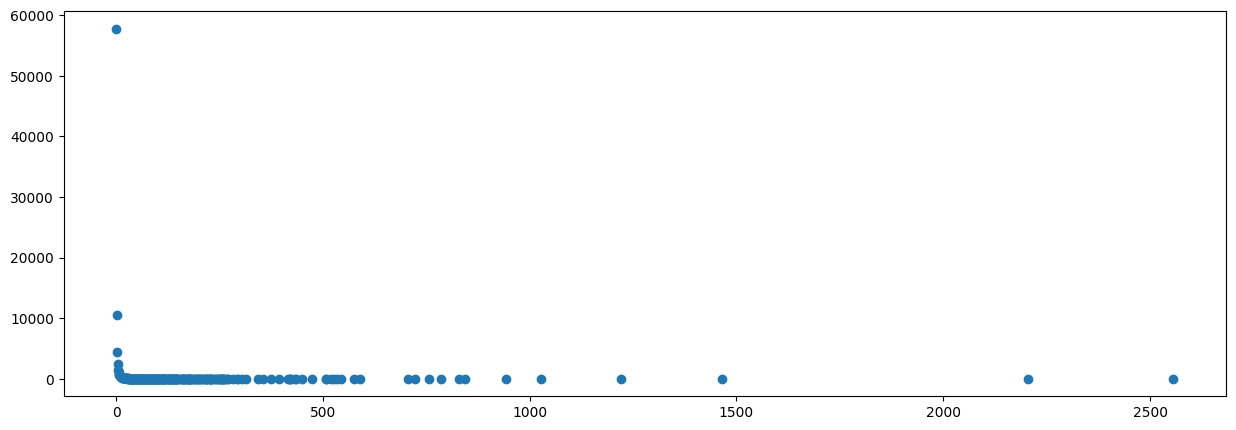

In [34]:
w_count_counter = Counter(w_count.values())
plt.figure(figsize=(15,5))
plt.scatter(list(w_count_counter.keys()), list(w_count_counter.values()))

<Figure size 640x480 with 0 Axes>

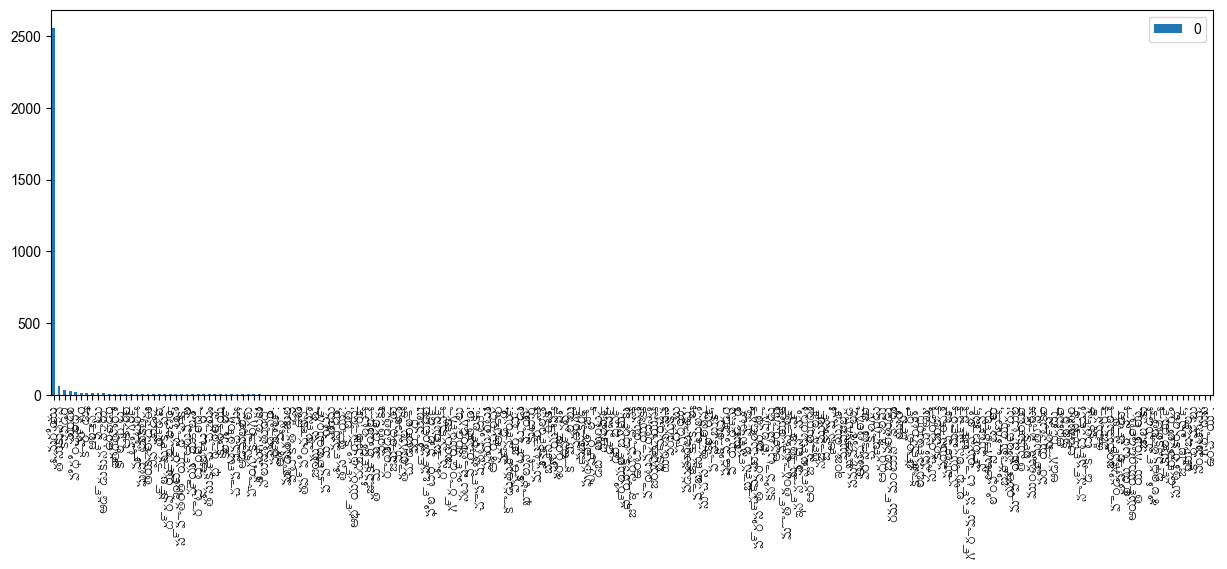

In [35]:
# fequency bar plot - samples
import matplotlib as mpl
plt.figure()
#plt.rcParams.update({'font.family': 'Vijaya'}) 
mpl.rcParams['font.sans-serif'] = ['Source Han Sans TW',
                                   'sans-serif',
                                   "Arial Unicode MS"  # fc-list :lang=hi family
                                   ]
#plt.rc('font', family='Vijaya')
ax = w_count_df.iloc[::400].plot.bar(figsize=(15,5))
plt.show()

<Axes: >

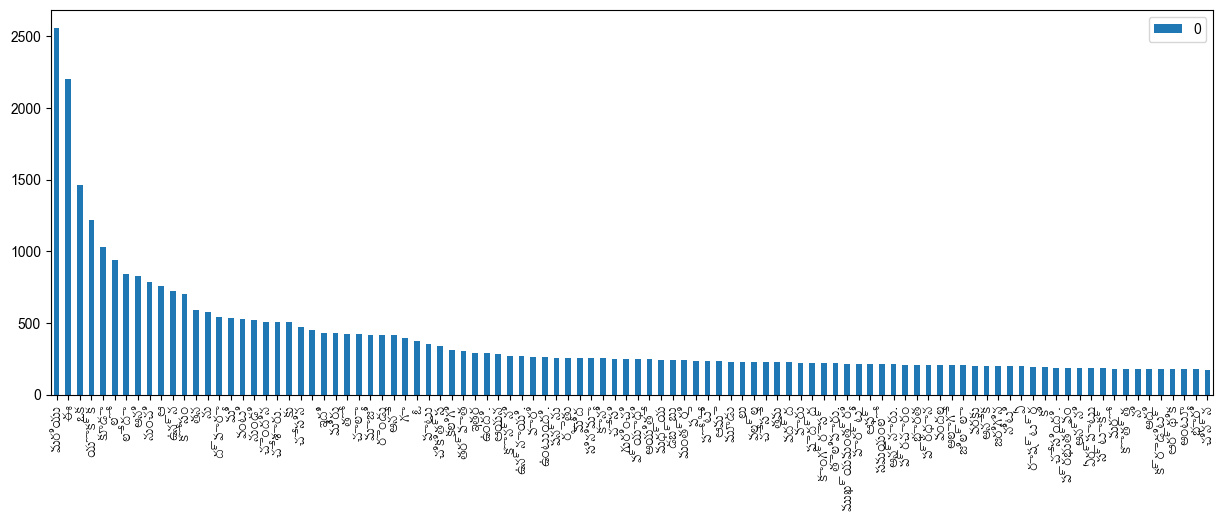

In [36]:
# fequency bar plot - first 100
w_count_df.iloc[:100].plot.bar(figsize=(15,5))

<Axes: >

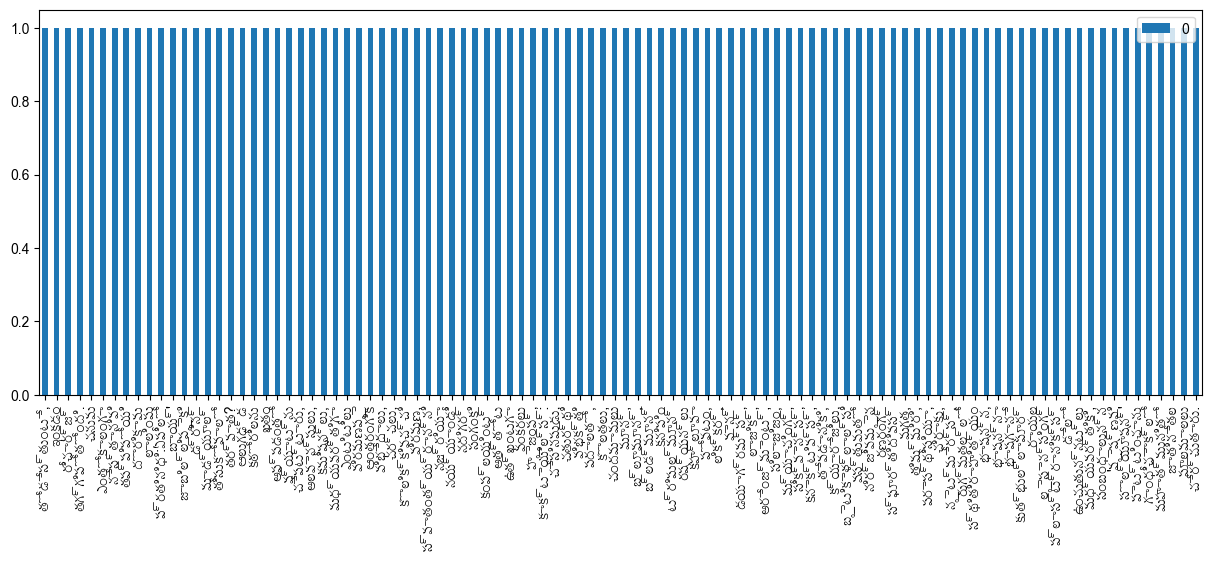

In [37]:
# fequency bar plot - tlastop 100
w_count_df.iloc[-100:].plot.bar(figsize=(15,5))

##### UNIQUE CHARACTERS

In [9]:
import os
import unicodedata

def extract_unique_chars_from_folder(folder_path):
    unique_chars = set()
    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            filepath = os.path.join(folder_path, filename)
            with open(filepath, 'r', encoding='utf-8') as file:
                for line in file:
                    line = unicodedata.normalize('NFC', line)  
                    unique_chars.update(line)  

    return sorted(unique_chars)  

folder_path = 'D:/THESIS/TTS_40HRS/Telugu_M/Telugu_M/txt/'
unique_characters = extract_unique_chars_from_folder(folder_path)
print(unique_characters)


[' ', '!', '"', '%', "'", '(', ')', '+', ',', '-', '.', ':', '?', 'o', 's', '।', 'ఁ', 'ం', 'ః', 'అ', 'ఆ', 'ఇ', 'ఈ', 'ఉ', 'ఊ', 'ఋ', 'ఎ', 'ఏ', 'ఐ', 'ఒ', 'ఓ', 'ఔ', 'క', 'ఖ', 'గ', 'ఘ', 'ఙ', 'చ', 'ఛ', 'జ', 'ఝ', 'ఞ', 'ట', 'ఠ', 'డ', 'ఢ', 'ణ', 'త', 'థ', 'ద', 'ధ', 'న', 'ప', 'ఫ', 'బ', 'భ', 'మ', 'య', 'ర', 'ఱ', 'ల', 'ళ', 'వ', 'శ', 'ష', 'స', 'హ', 'ా', 'ి', 'ీ', 'ు', 'ూ', 'ృ', 'ె', 'ే', 'ై', 'ొ', 'ో', 'ౌ', '్', 'ౕ', 'ౖ', 'ౙ', '౦', '\u200c', '‘', '’', '“', '”']


: 

In [40]:
import os
import librosa

# Path to the folder containing WAV files
folder_path = 'D:/THESIS/TTS_40HRS/Telugu_M/Telugu_M/wavs'

# Initialize variables for minimum, maximum, and total duration
min_duration = float('inf')  # Initialize to positive infinity
max_duration = 0
total_duration = 0
file_count = 0  # Counter for the number of files

# Iterate through each file in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.wav'):
        file_path = os.path.join(folder_path, file_name)
        # Load audio file and get its duration in seconds
        audio_data, _ = librosa.load(file_path, sr=None)  # sr=None to get the original sampling rate
        duration = librosa.get_duration(y=audio_data)

        # Update minimum and maximum durations
        min_duration = min(min_duration, duration)
        max_duration = max(max_duration, duration)
        total_duration += duration
        file_count += 1

# Calculate average duration
average_duration = total_duration / file_count if file_count > 0 else 0

# Print the results
print(f"Minimum duration: {min_duration:.2f} seconds")
print(f"Maximum duration: {max_duration:.2f} seconds")
print(f"Average duration: {average_duration:.2f} seconds")


Minimum duration: 2.36 seconds
Maximum duration: 23.40 seconds
Average duration: 8.93 seconds


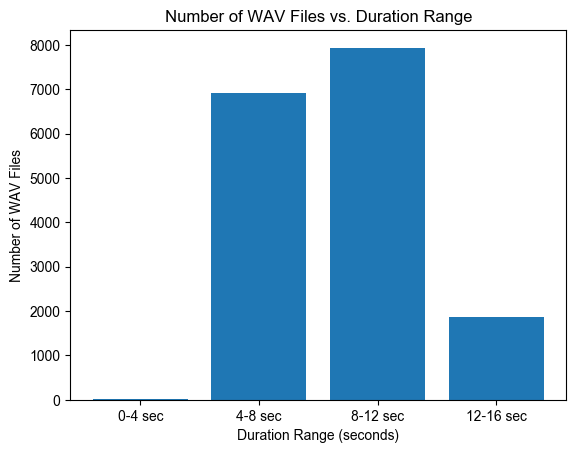

In [41]:
import os
import librosa
import matplotlib.pyplot as plt
import numpy as np

# Function to calculate the duration of a WAV file using librosa
def calculate_duration(wav_file):
    audio, sr = librosa.load(wav_file, sr=None)
    return librosa.get_duration(y=audio, sr=sr)

# Function to list all WAV files in a given directory
def list_wav_files(folder_path):
    wav_files = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.wav'):
                wav_files.append(os.path.join(root, file))
    return wav_files

# Input folder path
folder_path = 'D:/THESIS/TTS_40HRS/Telugu_M/Telugu_M/wavs'

# List all WAV files in the specified folder
wav_files = list_wav_files(folder_path)

# Calculate the duration for each WAV file
durations = [calculate_duration(file) for file in wav_files]

# Define the duration bins (0-4 seconds, 4-8 seconds, etc.)
duration_bins = [0, 4, 8, 12, 16]

# Count the number of WAV files in each duration bin
duration_counts = np.histogram(durations, bins=duration_bins)[0]

# Plotting the bar graph
plt.bar(range(len(duration_counts)), duration_counts, align='center')
plt.xticks(range(len(duration_counts)), [f'{duration}-{duration+4} sec' for duration in duration_bins[:-1]])
plt.xlabel('Duration Range (seconds)')
plt.ylabel('Number of WAV Files')
plt.title('Number of WAV Files vs. Duration Range')
plt.show()
